# This notebook builds a general stock market RNN then finetunes it for a particular basket of stocks

In [45]:
import tensorflow as tf
import os
from datetime import datetime
from pandas_datareader.exceptions import DEP_ERROR_MSG, ImmediateDeprecationError

In [46]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal
import pickle

In [47]:
import pandas as pd

## I run Tensorflow in Nvidia-Docker, which doesn't come with pandas_datareader installed 

In [48]:
!pip install pandas_datareader

In [49]:
from pandas_datareader import data as web

In [50]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 9)
start = datetime(2018,9,1)
stop = datetime(202,5,5)

In [51]:
# 'MSFT', 'GPRO', 'SBUX', 'BABA','FIT','GE','LUV''BAC','RTX','TWTR','DIS','AAPL', 'NFLX',

basket = ['TSLA', 'GOOGL', 'FB','RTX','TWTR','AAPL']
os.environ['ALPHAVANTAGE_API_KEY'] = "XFF5HEBRJ25DX4NR"

In [52]:
tsla = web.DataReader("TSLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))


In [53]:
# TODO: Should duplicate items in the basket in different orders to expand the training set

In [54]:
googl = web.DataReader("GOOGL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [55]:
fb = web.DataReader("FB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [56]:
twtr = web.DataReader("TWTR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [58]:
rtx = web.DataReader("RTX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [59]:
aapl = web.DataReader("AAPL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [61]:
aapl = aapl.copy()
aapl = aapl.reset_index()

tsla = tsla.copy()
tsla=tsla.reset_index()

fb = fb.copy()
fb=fb.reset_index()

rtx = rtx.copy()
rtx=rtx.reset_index()

aapl = aapl.copy()
aapl=aapl.reset_index()

googl = googl.copy()
googl=googl.reset_index()

twtr = twtr.copy()
twtr=twtr.reset_index()

In [62]:
my_frames = [googl,fb,twtr,rtx,aapl,tsla]
basket = ['GOOGL', 'FB','TWTR','RTX','AAPL','TSLA']


aapl['symbol'] = "AAPL"
googl['symbol'] ='GOOGL'
fb['symbol'] = 'FB'
twtr['symbol'] ='TWTR'
rtx['symbol'] ='RTX'
tsla['symbol'] = 'TSLA'
df = pd.concat([aapl,googl, fb, twtr, rtx, tsla], ignore_index = True)
sum(df['symbol']=='GOOGL')

3955

# Feature engineering

De-trend and add a few extra features

In [63]:
X_scalers = {}
y_scalers = {}
for stock in basket:
    for col in ('close', 'high', 'low', 'open', 'volume'):
        df[col] = df[col].astype(float)
        df.loc[df['symbol'] == stock, col] = signal.detrend(df[df['symbol'] == stock][col])
    df.loc[df['symbol'] == stock, 'mean_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).mean()
    df.loc[df['symbol'] == stock, 'mean_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).mean()
    df.loc[df['symbol'] == stock, 'std_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).std()
    df.loc[df['symbol'] == stock, 'std_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).std()

In [64]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

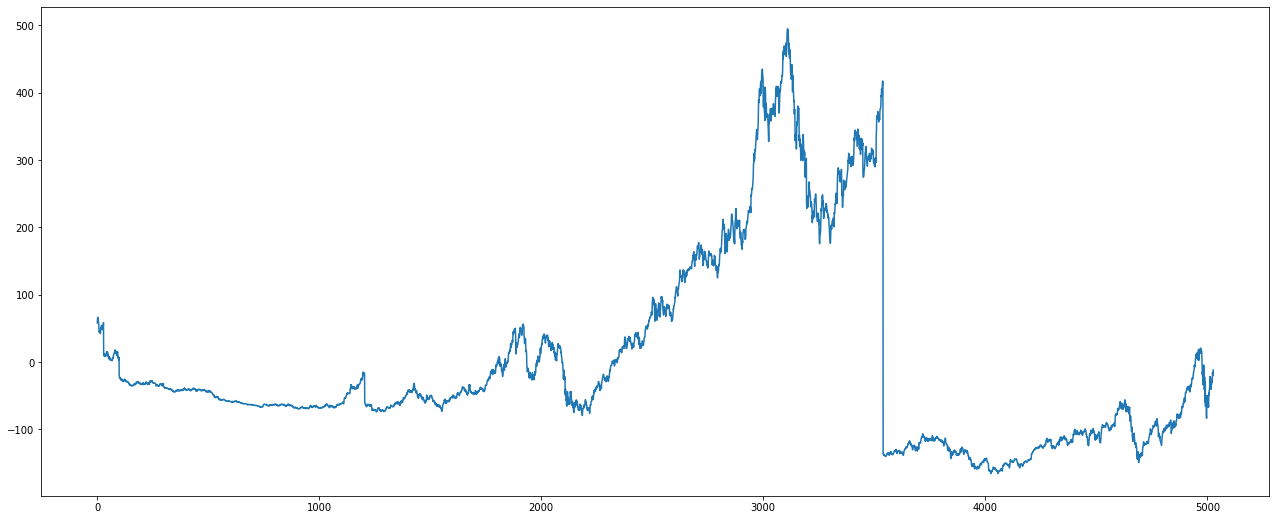

In [65]:
plt.plot(df[df['symbol'] == 'AAPL']['close'])
plt.show()

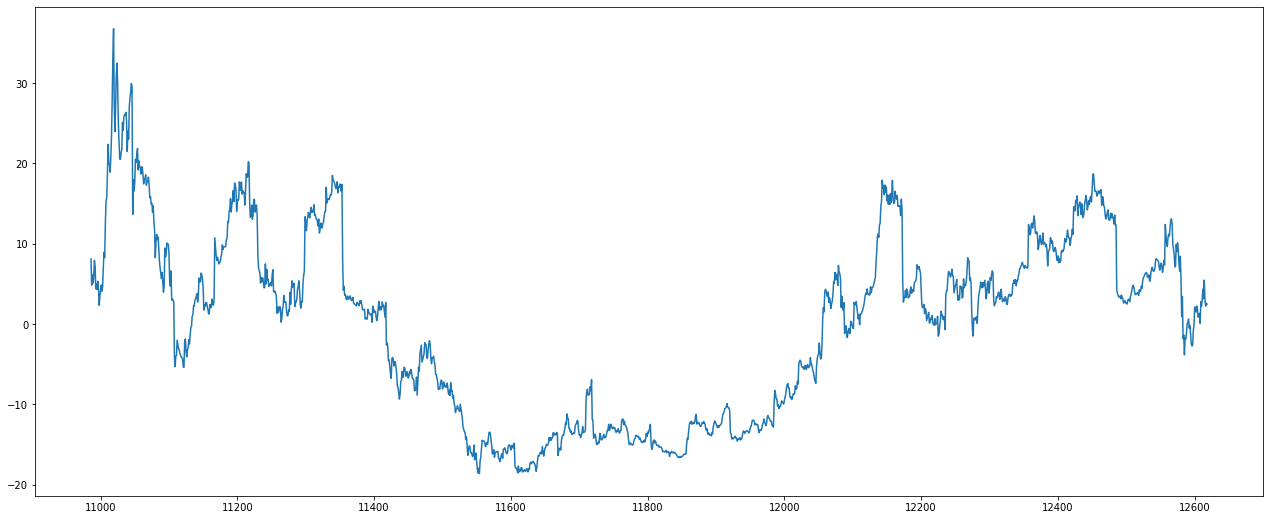

In [66]:
plt.plot(df[df['symbol'] == 'TWTR']['close'])
plt.show()

In [67]:
df['tomo_gain'] = df['close'].shift(-1) - df['close']
df['yday_gain'] = df['tomo_gain'].shift(1)

# This is not ok - note the last one

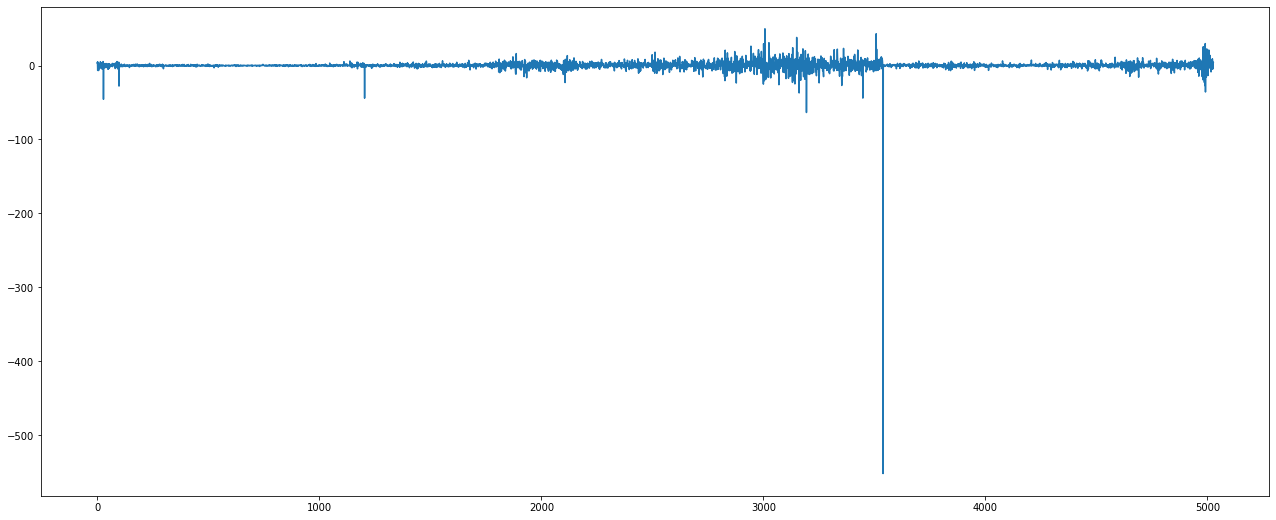

In [68]:
plt.plot(df[df['symbol'] == 'AAPL'][:-1]['tomo_gain'])
plt.show()

# This is better

In the for loop below, the last row of each stock symbol is dropped.

In [69]:
plt.show()
df[df['symbol']=='TWTR']

,level_0,index,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain
10986,NaN,2013-11-07,8.220178,12.445870,7.929770,8.089273,9.384665e+07,TWTR,NaN,NaN,NaN,NaN,-3.243134,11.760273
10987,NaN,2013-11-08,9.057098,9.303006,4.621438,4.846140,4.072703e+06,TWTR,6.467707,NaN,2.293242,NaN,1.256866,-3.243134
10988,NaN,2013-11-11,3.634018,5.370141,3.343107,6.103006,-7.736349e+06,TWTR,5.474573,6.346140,0.888739,1.635180,-0.993134,1.256866
10989,NaN,2013-11-12,6.800938,6.157276,5.779776,5.109873,-1.753120e+07,TWTR,5.606440,5.353006,0.702251,0.662770,0.706866,-0.993134
10990,NaN,2013-11-13,4.177858,5.254411,4.716445,5.816739,-1.515725e+07,TWTR,5.463306,5.676539,0.499830,0.511195,2.096866,0.706866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,NaN,2020-04-29,4.445847,5.472134,4.406652,5.457890,9.264688e+06,TWTR,4.304457,4.321024,1.631201,1.153790,-2.403134,2.306866
12615,NaN,2020-04-30,3.182767,4.549269,2.878321,3.054757,4.874675e+07,TWTR,4.256324,3.887890,1.699272,1.360512,-0.833134,-2.403134
12616,NaN,2020-05-01,2.399687,2.431405,1.991490,2.221623,8.184808e+06,TWTR,2.638190,3.578090,0.589114,1.680406,0.396866,-0.833134
12617,NaN,2020-05-04,2.006606,2.413540,2.196659,2.618490,-2.331214e+06,TWTR,2.420056,2.631623,0.280627,0.416722,-0.153134,0.396866


# Create datetime features

In [70]:
def completed_quarter(dt):
    prev_quarter_map = ((4, -1), (1, 0), (2, 0), (3, 0))
    quarter, yd = prev_quarter_map[(dt.month - 1) // 3]
    return  quarter

In [71]:

for stock in basket:
    days =[]
    weeks = []
    quarter = []
    as_date = []   
    for x in df.loc[df['symbol'] == stock,'index']:
        as_date.append(datetime.strptime(x, '%Y-%m-%d'))
    for date in as_date:
        days.append(date.day)
        weeks.append(date.isocalendar()[1])
        quarter.append(completed_quarter(date))
    df.loc[df['symbol'] == stock,'dayofweek'] = days
    df.loc[df['symbol'] == stock,'quarter'] = quarter
    df.loc[df['symbol'] == stock,'weekofyear'] = weeks


In [72]:
df.head()
df = df.drop(['level_0','index'],axis=1)

In [73]:

df = df.dropna(axis=0)
df[df['symbol'] == 'GOOGL']

,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
5030,-119.897140,-120.404056,-117.896467,-120.782281,1.790809e+06,GOOGL,-121.214450,-123.941619,0.611180,4.743325,-4.755661,0.864339,23.0,2.0,35.0
5031,-119.642623,-122.511127,-123.600360,-125.537942,-1.213207e+06,GOOGL,-123.160111,-122.655614,3.362760,2.533304,0.904339,-4.755661,24.0,2.0,35.0
5032,-126.348107,-126.338198,-123.514253,-124.633603,-7.267122e+06,GOOGL,-125.085773,-123.651275,0.639464,2.525432,1.684339,0.904339,25.0,2.0,35.0
5033,-126.383590,-126.615269,-122.958146,-122.949264,-9.356138e+06,GOOGL,-123.791434,-124.373603,1.191007,1.313778,-1.985661,1.684339,26.0,2.0,35.0
5034,-123.459073,-126.172339,-122.152039,-124.934926,-1.023445e+07,GOOGL,-123.942095,-124.172598,1.404075,1.070097,-4.365661,-1.985661,27.0,2.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8978,224.134369,229.790271,215.854414,221.087225,7.840081e+06,GOOGL,166.405055,161.009553,77.332266,55.474985,4.294339,109.364339,29.0,1.0,18.0
8979,210.268886,219.413200,210.400521,225.381563,5.219101e+06,GOOGL,223.234394,186.063891,3.036556,64.416994,-29.605661,4.294339,30.0,1.0,18.0
8980,202.773402,220.616129,198.336628,195.775902,4.875315e+06,GOOGL,210.578733,214.081563,20.934364,15.997914,5.354339,-29.605661,1.0,1.0,18.0
8981,186.587919,193.429059,184.462736,201.130241,3.972221e+06,GOOGL,198.453072,207.429236,3.786089,15.775988,25.894339,5.354339,4.0,1.0,19.0


In [74]:
for stock in basket:
    df = df.drop(df.index[len(df[df['symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['symbol'] == stock]['tomo_gain']) < df[df['symbol'] == stock]['tomo_gain'].std() * 3
    df[df['symbol'] == stock] = df[df['symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    pre_y = df[df['symbol'] == stock]['tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    for col in ('close', 'high', 'low', 'open', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = df[df['symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['symbol'] == stock, 'tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

# Save the feature scalers

In [75]:
pickle.dump(X_scalers, open('x_scalers.pkl', 'wb'))
pickle.dump(y_scalers, open('y_scalers.pkl', 'wb'))

# Note same shape but now different scale

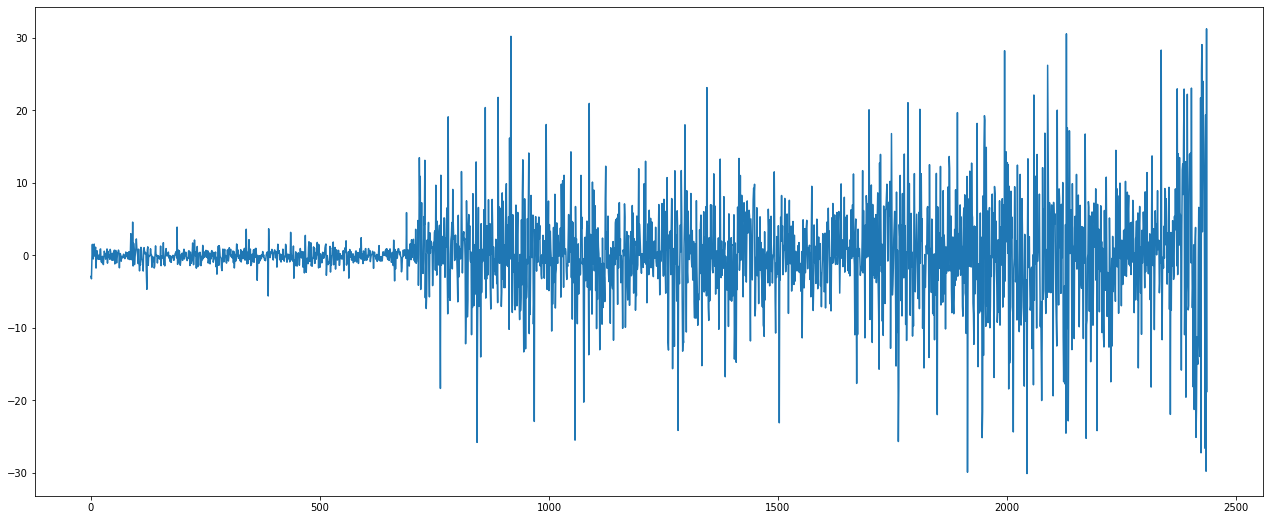

In [76]:
plt.plot(pre_y)
plt.show()

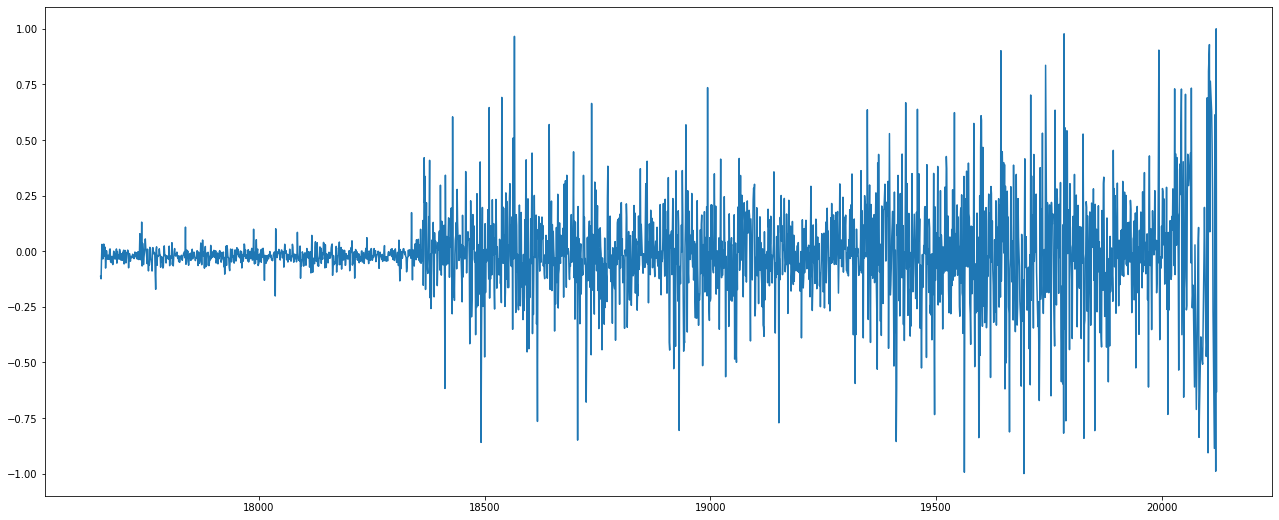

In [77]:

plt.plot( df.loc[df['symbol'] == basket[-1], 'tomo_gain'])

In [78]:
df = df.dropna(axis=0)

In [79]:
df[df['symbol'] == 'AAPL'].describe()


,open,high,low,close,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
count,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000,5005.000000
mean,-0.499615,-0.497711,-0.503983,-0.500282,-0.714594,-0.500358,-0.501447,-0.990760,-0.985463,0.019111,0.834846,15.752647,2.489510,26.673526
std,0.426343,0.428949,0.423580,0.426372,0.174782,0.426210,0.426938,0.031234,0.043589,0.150247,0.029886,8.753871,1.112093,14.949318
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000
25%,-0.755741,-0.755244,-0.760125,-0.756328,-0.822394,-0.756654,-0.758054,-0.998406,-0.996886,-0.023317,0.831480,8.000000,1.000000,14.000000
50%,-0.638891,-0.638810,-0.642695,-0.640091,-0.766091,-0.640095,-0.641492,-0.995796,-0.992407,0.015043,0.834904,16.000000,2.000000,27.000000
75%,-0.418147,-0.413058,-0.425669,-0.418336,-0.646527,-0.418736,-0.420248,-0.989153,-0.982600,0.064310,0.839259,23.000000,3.000000,40.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,4.000000,53.000000


In [80]:
num_df_cols = df.shape[1] - 1 + len(basket) - 1
print(num_df_cols)
df.shape

19


(19918, 15)

In [81]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

In [82]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [83]:
X = df.drop(['tomo_gain','symbol'], axis=1)
y = df['tomo_gain']

In [84]:
dummies = pd.get_dummies(df['symbol'], columns=['symbol'])

In [85]:
X = np.append(X, dummies.values, axis=1)

In [86]:
X.shape


(19918, 19)

In [87]:
# Reshape to num_samples, timesteps, num_features
X = np.reshape(X,(-1, 1, num_df_cols))

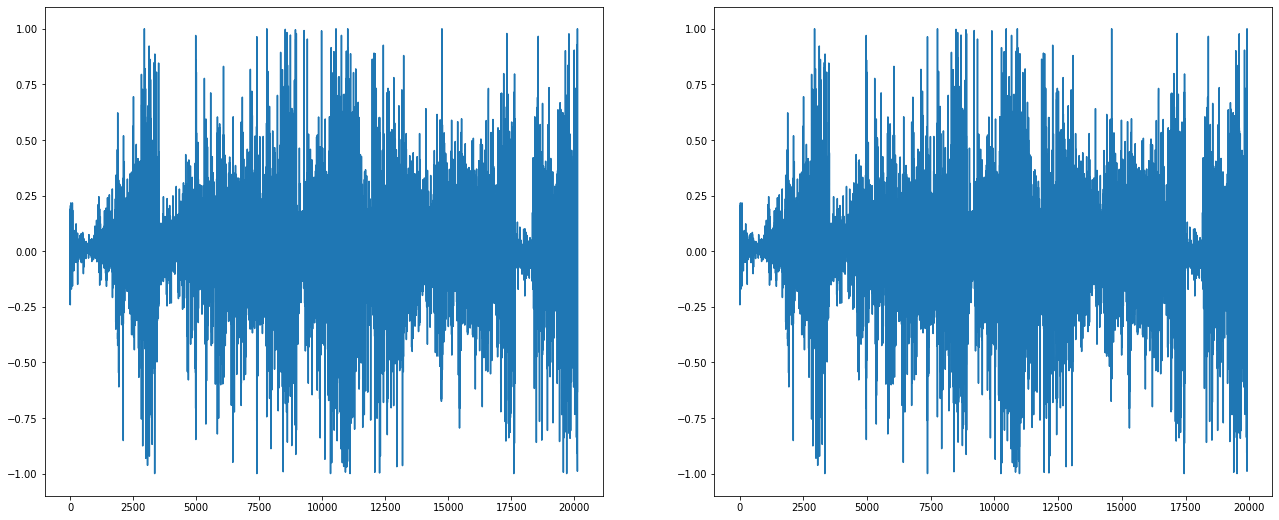

In [88]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['tomo_gain'].values)

# Fit the base model

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=64, epochs=1000, verbose=0)
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=32, epochs=6)

In [ ]:
model.evaluate(X_test, y_test)

# Sanity checks

In [ ]:
model.reset_states()

In [ ]:
plt.plot(model.predict(X))

In [ ]:
plt.plot(y)

In [ ]:
plt.plot(y_scalers['EAT'].inverse_transform(model.predict(X[100:120])))

In [ ]:
plt.plot(y[100:120])

In [ ]:
plt.plot(y[482:728]) # the range for TTNP

In [ ]:
plt.plot(y_scalers['TTNP'].inverse_transform(model.predict(np.reshape(X[482:728], (-1, 1, num_df_cols)))))

In [ ]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [ ]:
pad_stock('TWTR')

In [ ]:
model.save('market_model.h5')

In [ ]:
#model = tf.keras.models.load_model('market_model.h5')

## Pop off the model head and add a different one that we will finetune per stock

In [ ]:
model.layers

In [ ]:
model.pop()
model.pop()

In [ ]:
# Freeze the 2 older dense layers
model.layers[0].trainable = False
model.layers[3].trainable = False

In [ ]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [ ]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

In [ ]:
specific_models['EAT'].layers

In [ ]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [ ]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['tomo_gain', 'symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['tomo_gain'].values.reshape(-1,1)

In [ ]:
Xes_train, ys_train, Xes_test, ys_test, best_model_scores, best_model = {}, {}, {}, {}, {}, {}

In [ ]:
for stock in basket:
    best_model_scores[stock] = 1e6
for stock in basket:
    Xes_train[stock] = Xes[stock][:-5]
    ys_train[stock] = ys[stock][:-5]
    Xes_test[stock] = Xes[stock][-5:]
    ys_test[stock] = ys[stock][-5:]
    for i in range(8):
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=64, epochs=100, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=16, epochs=30, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=1, epochs=1, verbose=0)
        evaluation = specific_models[stock].evaluate(Xes_test[stock], ys_test[stock])[0]
        if evaluation < best_model_scores[stock]:
            best_model_scores[stock] = evaluation
            print('now saving {} because it was the best with eval score {}'.format(stock, evaluation))
            best_model[stock] = tf.keras.models.clone_model(specific_models[stock])
            best_model[stock].set_weights(specific_models[stock].get_weights())
            best_model[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        else:
            print('did not save {} because it did not improve with eval score {}'.format(stock, evaluation))

# Now let's reassign it for simplicity

In [ ]:
for stock in basket:
    specific_models[stock] = best_model[stock]

# Sanity checks

In [ ]:
plt.plot(y_scalers['TWTR'].inverse_transform(specific_models['TWTR'].predict(Xes['TWTR'])))

In [ ]:
plt.plot(ys['TWTR'])

In [ ]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

In [ ]:
plt.plot(y_scalers['EAT'].inverse_transform(specific_models['EAT'].predict(Xes['EAT'][100:120])))

# Make some predictions for tomorrow

I'm not sure if these have valid units by now, but definitely larger numbers mean higher gains, and v.v. Note that the RNN should be warmed up on a few previous days' data first; one-off predictions will not be as good so don't use it like this (see below instead).

In [ ]:
for stock in basket:
    today = df[df['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred)))

# Save the fine tuned models

In [ ]:
for stock, model in specific_models.items():
    model.save('finetuned_{}.h5'.format(stock))

# With the models built, run this to generate new predictions for the most recent day

In [ ]:
X_scalers = pickle.load(open('x_scalers.pkl', 'rb'))
y_scalers = pickle.load(open('y_scalers.pkl', 'rb'))

In [ ]:
specific_models = {}
for stock in basket:
    specific_models[stock] = tf.keras.models.load_model('finetuned_{}.h5'.format(stock))

In [ ]:
new_day = data.DataReader(basket, 'robinhood')

In [ ]:
new_day.tail()

In [ ]:
new_day = new_day.reset_index()

In [ ]:
for stock in basket:
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume'):
        new_day[col] = new_day[col].astype(float)
        new_day.loc[new_day['symbol'] == stock, col] = signal.detrend(new_day[new_day['symbol'] == stock][col])
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=2).mean()
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=3).mean()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=2).std()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close_price'].rolling(window=3).std()

In [ ]:
new_day['tomo_gain'] = new_day['close_price'].shift(-1) - new_day['close_price']
new_day['yday_gain'] = new_day['tomo_gain'].shift(1)

In [ ]:
as_date = new_day['begins_at'].dt
new_day['dayofweek'] = as_date.dayofweek
new_day['quarter'] = as_date.quarter
new_day['weekofyear'] = as_date.weekofyear
new_day = new_day.drop(['begins_at', 'interpolated', 'session'], axis=1)
new_day = new_day.dropna(axis=0)
new_day = new_day.reset_index(drop=True)
for stock in basket:
    new_day = new_day.drop(new_day.index[len(new_day[new_day['symbol'] == stock]) - 1], axis=0)
    outliers = abs(new_day[new_day['symbol'] == stock]['tomo_gain']) < new_day[new_day['symbol'] == stock]['tomo_gain'].std() * 3
    new_day[new_day['symbol'] == stock] = new_day[new_day['symbol'] == stock].loc[:, :][outliers]
    new_day = new_day.drop(new_day[new_day['symbol'] == stock].iloc[-1].name)
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = new_day[new_day['symbol'] == stock][col]
        new_day.loc[new_day['symbol'] == stock, col] = X_scalers[stock][col].transform(pre_x.values.reshape(-1,1))

In [ ]:
new_day = new_day.dropna(axis=0)

In [ ]:
dummies = pd.get_dummies(new_day['symbol'], columns=['symbol'])
num_df_cols = new_day.shape[1] - 1 + len(basket) - 1
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

# Today: This should be better

In [ ]:
for stock in basket:
    today = new_day[new_day['symbol'] == stock].iloc[-8:-1].drop(['tomo_gain', 'symbol'], axis=1)
    today = np.append(today, pad_stock(stock).reshape(-1,9).repeat(7,axis=0))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred[-1])))